# Classical Random Circuits

Here we use classical circuits to get a handle on error rates.

This module that generates classical random circuits (that are not universal) on a graph which represents the QPU or QVM lattice. The basic idea is it will compute error rates of circuits as a function of depth and width.

The `width` of the circuit is the number of connected vertices on a particular subgraph.

The `depth` is defined in an unusual way. We consider a "depth 1" circuit to be a round of X gates randomly applied or not to a particular vertex AND a round of CNOTs randomly applied or not to each edge of the graph.

The circuit can also be executed in the X basis.

## Imports

In [1]:
import random
import itertools
import networkx as nx
import numpy as np
import pandas as pd
import time
from scipy.spatial.distance import hamming
import scipy.interpolate

from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer
from pyquil.gates import CNOT, CCNOT, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma

from forest_benchmarking.classical_random_circuits import *

## Get lattice

In [2]:
# if you want to run on a "real lattice"
#from pyquil import *
#list_quantum_computers()
#qc_perfect = get_qc("Aspen-1-15Q-A", as_qvm=True, noisy=False)
#qc_noisy = get_qc("Aspen-1-15Q-A", as_qvm=True, noisy=True)

qc_perfect = get_qc("9q-square-qvm", as_qvm=True, noisy=False)
qc_noisy = get_qc("9q-square-qvm", as_qvm=True, noisy=True)

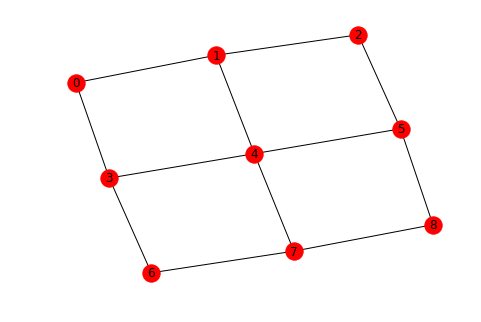

In [3]:
nx.draw(qc_perfect.qubit_topology(),with_labels=True)

# Plot the distribution of sublattice widths

[9, 12, 22, 36, 49, 48, 32, 9, 1]

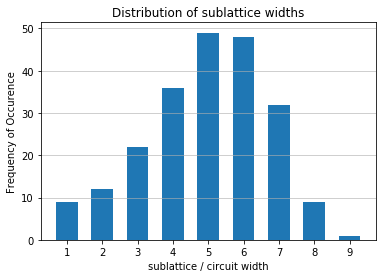

In [4]:
G = qc_perfect.qubit_topology()
len(qc_perfect.qubit_topology())
# distribution of graph lengths
disty = []
for gdx in range(1,len(G.nodes)+1):
    listg = generate_connected_subgraphs(G,gdx)
    disty.append(len(listg))

cir_wid = list(range(1,len(G.nodes)+1))
plt.bar(cir_wid, disty, width=0.61, align='center')
plt.xticks(cir_wid)
plt.xlabel('sublattice / circuit width')
plt.ylabel('Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of sublattice widths')
disty

# Acquire data

In [5]:
# with these parameters the cell below takes about 2 minutes
num_shots_per_circuit = 100
num_rand_subgraphs = 6
circuit_depth = 8
circuit_width = 6 #max = len(G.nodes)
in_x_basis = False
use_active_reset = False

In [6]:
t0 = time.time()
data = get_random_classical_circuit_results(qc_perfect, qc_noisy, circuit_depth, circuit_width, num_rand_subgraphs, num_shots_per_circuit)
t1 = time.time()
total = t1-t0
print(total)

107.61140990257263


Now put the data into a dataframe

In [7]:
df = pd.DataFrame(data)
df

,depth,hamming_dist,width
0,1,"[0.93, 0.0]",1
1,1,"[0.865, 0.13333333333333333, 0.0]",2
2,1,"[0.8633333333333333, 0.13166666666666665, 0.00...",3
3,1,"[0.7433333333333333, 0.23333333333333334, 0.02...",4
4,1,"[0.7183333333333334, 0.24833333333333332, 0.03...",5
5,1,"[0.6766666666666666, 0.2683333333333333, 0.046...",6
6,2,"[0.9616666666666667, 0.0]",1
7,2,"[0.8866666666666667, 0.10833333333333334, 0.0]",2
8,2,"[0.7883333333333333, 0.20166666666666666, 0.01...",3
9,2,"[0.7966666666666666, 0.185, 0.0183333333333333...",4


# Plot a particular depth and width

In [8]:
dep = 2
wid = 2

distz = get_hamming_dist(df, dep, wid)
averaged_distr = distz['hamming_dist'][0]
rand_ans_distr = hamming_dist_rand(wid,0)

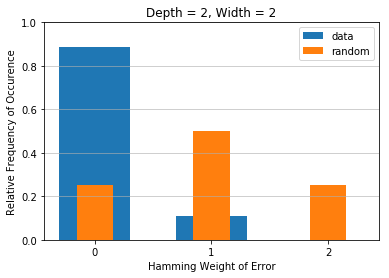

In [9]:
x_labels = np.arange(0, len(averaged_distr))
plt.bar(x_labels, averaged_distr, width=0.61, align='center')
plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurence')
plt.ylim([0,1])
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.show()

# For a particular width plot all depths

In [10]:
wid = 4
hdis = get_hamming_dists_fn_depth(df, wid)

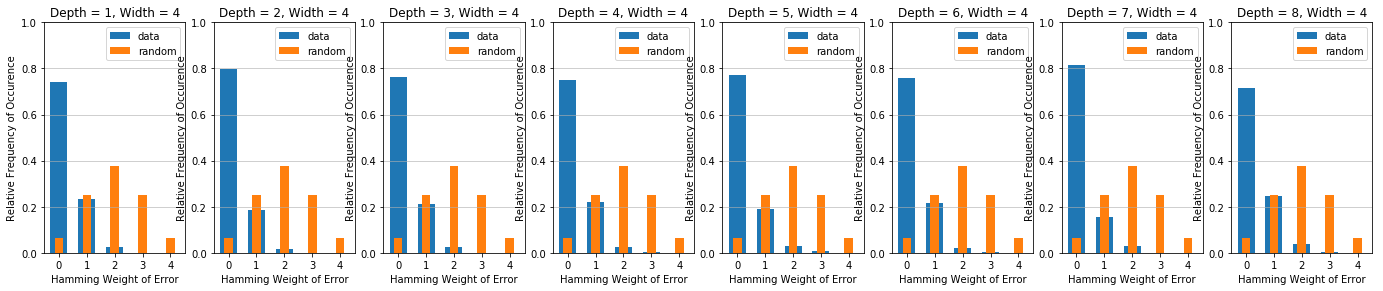

In [11]:
for hdx in range(0, len(hdis)):
    averaged_distr = hdis.iloc[hdx]['hamming_dist']
    dep = hdis.iloc[hdx]['depth']
    rand_ans_distr = hamming_dist_rand(wid,0)
    x_labels = np.arange(0, len(averaged_distr))
    plt.subplot(1,len(hdis),hdx+1)
    plt.bar(x_labels, averaged_distr, width=0.61, align='center')
    plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()

Now we can study the sucess probablity, i.e. the zero hamming weight entry above as a function of depth. We first need to extract the data fron the data frame.

In [12]:
num_bit_flips_allowed_from_answer = int(basement_function(np.log2(wid)-1))

pcheck = []
pcheck_rand = []
depth_vec = []
pcheck_log_errors = []
rand_pcheck_log_errors = []

for hdx in range(0, len(hdis)):
    averaged_distr = hdis.iloc[hdx]['hamming_dist']
    # probablity of getting the correct answer
    pcheck.append(averaged_distr[0])
    rand_ans_distr = hamming_dist_rand(wid,0)
    # probablity of getting the correct by randomly guessing
    pcheck_rand.append(rand_ans_distr[0])
    # error when you allow for a logarithmic number of bit flips from the true answer
    pcheck_log_errors.append(sum([averaged_distr[idx] for idx in range(0,num_bit_flips_allowed_from_answer+1)]))
    rand_pcheck_log_errors.append(sum([rand_ans_distr[idx] for idx in range(0,num_bit_flips_allowed_from_answer+1)]))
    dep = hdis.iloc[hdx]['depth']
    depth_vec.append(dep)

Next we will plot the sucess probablity of a circuit with a certain width as a function of depth. 

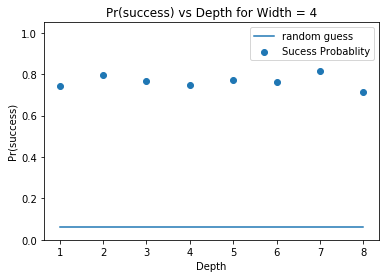

In [13]:
plt.scatter(depth_vec,pcheck,label='Sucess Probablity')
plt.plot(depth_vec,pcheck_rand,label='random guess')
plt.ylim([0,1.05])
plt.xlabel('Depth')
plt.ylabel('Pr(success)')
plt.title('Pr(success) vs Depth for Width = {}'.format(wid))
plt.legend()
plt.show()

Now we allow a logarithmic number of bits to flip from the correct answer and call all such instances "success". E.g.

The logarithmic number of bits that we allow to flip is defined by the "basement" of 

$\log_2 ({\rm number\ of\ bits}) -1$

where the basement of a number is ${\rm basement(number)} = 0$ if number$<=0$ and ${\rm basement(number)} = {\rm floor (number)}$.


Supose we have a circuit of width 4, this means correct string has four bits, e.g. 1010. Then a logarithmic number of flips is $\log_2(4)-1 = 1$.

So any string with hamming weight zero or one counts as a success.

Such error metrics might be important in noisy near term algorithms where getting the exact answer is not vital.

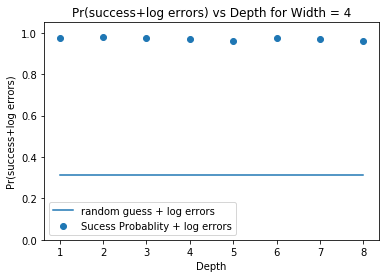

In [14]:
plt.figure()
plt.scatter(depth_vec,pcheck_log_errors,label='Sucess Probablity + log errors')
plt.plot(depth_vec,rand_pcheck_log_errors,label='random guess + log errors')
plt.ylim([0,1.05])
plt.xlabel('Depth')
plt.ylabel('Pr(success+log errors)')
plt.title('Pr(success+log errors) vs Depth for Width = {}'.format(wid))
plt.legend()
plt.show()

# Plot depth = width

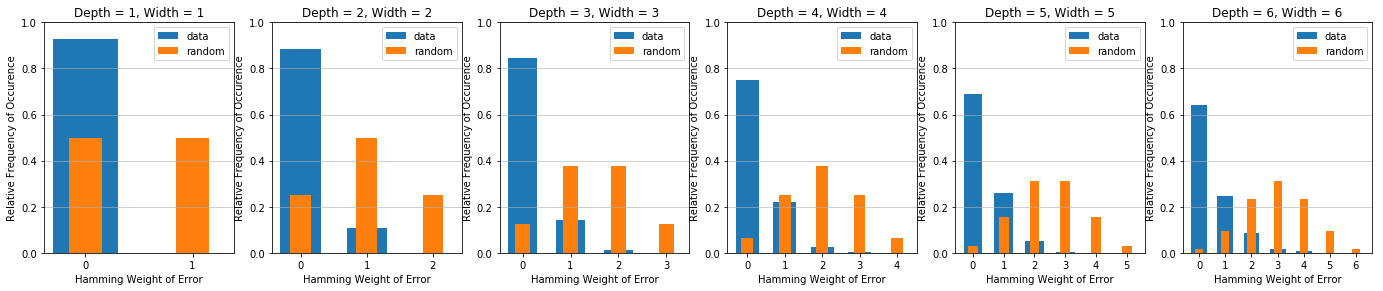

In [15]:
max_idx = min([max(df['depth']),max(df['width'])])

for idx in range(1,max_idx+1):
    hdis = get_hamming_dist(df, idx, idx)
    averaged_distr = hdis['hamming_dist'][0]
    dep = hdis['depth'][0]
    wid = hdis['width'][0]
    rand_ans_distr = hamming_dist_rand(idx,0)
    x_labels = np.arange(0, len(averaged_distr))
    plt.subplot(1,max_idx,idx)
    plt.bar(x_labels, averaged_distr, width=0.61, align='center')
    plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()

# Plot success probablity landscape

This is just the success probablity as a function of depth and width.

In [16]:
points = np.vstack((df['depth'].values, df['width'].values)).T
points.shape

(48, 2)

In [17]:
# df['hamming_dist'][0] returns the array
# df['hamming_dist'][0][0] returns the first element of the array
values = np.asarray([df['hamming_dist'][idx][0] for idx in df.index])
values

array([0.93      , 0.865     , 0.86333333, 0.74333333, 0.71833333,
       0.67666667, 0.96166667, 0.88666667, 0.78833333, 0.79666667,
       0.72833333, 0.70666667, 0.93      , 0.85666667, 0.84666667,
       0.765     , 0.715     , 0.67      , 0.96333333, 0.905     ,
       0.86333333, 0.74833333, 0.77333333, 0.61333333, 0.95      ,
       0.88      , 0.76666667, 0.77333333, 0.68833333, 0.68166667,
       0.95      , 0.9       , 0.81      , 0.76      , 0.67666667,
       0.64166667, 0.95166667, 0.89666667, 0.79333333, 0.81333333,
       0.7       , 0.60166667, 0.94      , 0.90166667, 0.855     ,
       0.715     , 0.675     , 0.66333333])

In [18]:
rand_width = [hamming_dist_rand(idx, 0)[0] for idx in range(1,circuit_width+1)]
rand_width

values_rand = np.asarray([item for sublist in [rand_width for ddx in range(1,circuit_depth+1)] for item in sublist])
values_rand.shape

(48,)

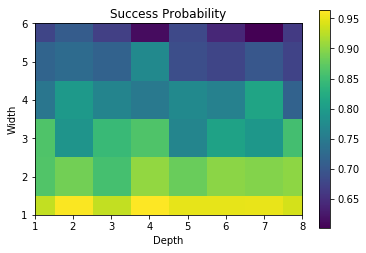

In [19]:
xx, yy, zz = interpolate_2d_landscape(points, values)

ax = plt.gca()
img = ax.imshow(zz, interpolation='none',
                extent=(xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]),
                cmap='viridis', origin='lowerleft', norm=plt.Normalize(None, None))
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability')
plt.show()

(48, 2)


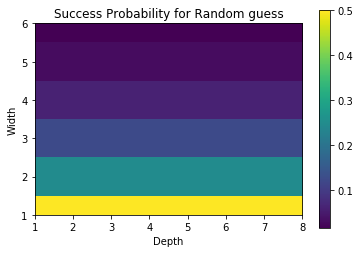

In [20]:
print(points.shape)
xx, yy, zz = interpolate_2d_landscape(points, values_rand)

ax = plt.gca()
img = ax.imshow(zz, interpolation='none',
                extent=(xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]),
                cmap='viridis', origin='lowerleft', norm=plt.Normalize(None, None))
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability for Random guess')
plt.show()